In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from utils import misc
import datetime as dt

from simple_backtester import backTester
df = pd.read_csv('datasets/daily_price_series/SPY.csv')
df = misc.clean_df(df)
df = df.set_index('date')

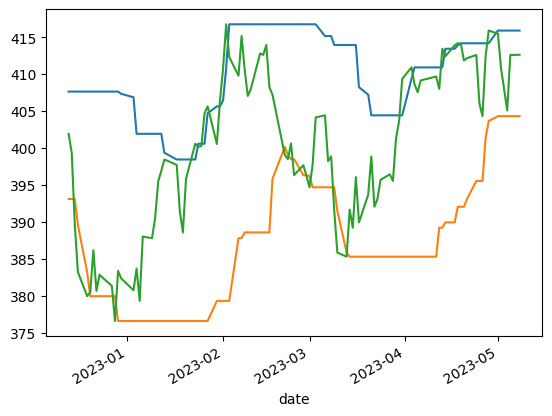

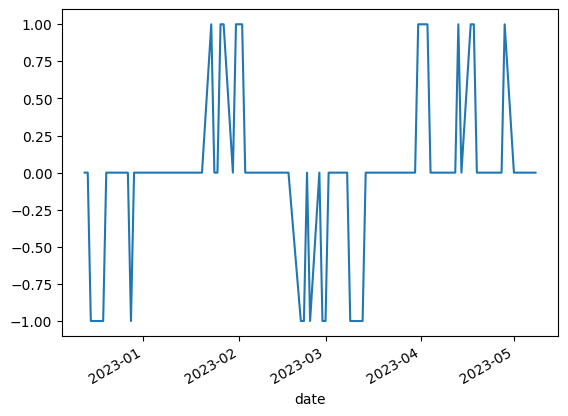

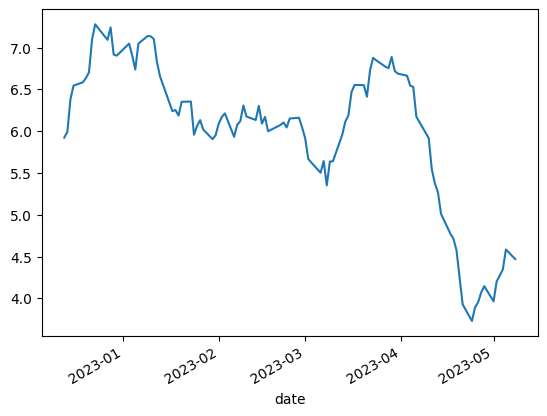

In [31]:
df['20_up_bound'] = df['close'].shift(1).rolling(20).max()
df['20_low_bound'] = df['close'].shift(1).rolling(20).min()
df['10_up_bound'] = df['close'].shift(1).rolling(10).max()
df['10_low_bound'] = df['close'].shift(1).rolling(10).min()


df = df.dropna()

signal = []
for i in range(len(df)):
    if df['close'][i] > df['20_up_bound'][i]:
        signal.append(1)
    elif df['close'][i] < df['20_low_bound'][i]:
        signal.append(-1)
    else:
        signal.append(0)

df['entry_signal'] = signal

signal = []
for i in range(len(df)):
    if df['close'][i] > df['10_up_bound'][i]:
        signal.append(1)
    elif df['close'][i] < df['10_low_bound'][i]:
        signal.append(-1)
    else:
        signal.append(0)

df['exit_signal'] = signal


df['High-Low'] = df['high'] - df['low']
df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
df['ATR'] = df['TR'].rolling(20).mean()

# df['returns'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
# df['vol'] = df['returns'].rolling(20).std()


df1 = df[-100:].copy()
df1['20_up_bound'].plot()
df1['20_low_bound'].plot()
df1['close'].plot()
plt.show()

df1['signal'].plot()
plt.show()

df1['ATR'].plot()
plt.show()

In [2]:
bt = backTester()




bt.set_asset(df)

trade_list = []
for i in range(len(df)):
    if df['signal'][i] < 0 and df['signal+1'][i] > 0:
        trade_list.append(1)
    elif df['signal'][i] > 0 and df['signal+1'][i] < 0:
        trade_list.append(-1)
    else:
        trade_list.append(0)

df['trade_list'] = trade_list
for i in range(len(trade_list)):
    if bt.open_trade == None:
        if trade_list[i] > 0:
            order_quantity = (bt.cash // bt.adjclose[i]) * trade_list[i]
        else:
            order_quantity = 0
    else:
        if trade_list[i] == -1 or bt.date[i] - bt.open_trade.entry_date > dt.timedelta(days=40):
        # if trade_list[i] == -1:
            order_quantity = bt.position * -1
        else:
            order_quantity = 0
    bt.take_action(order_quantity=order_quantity)

        


end


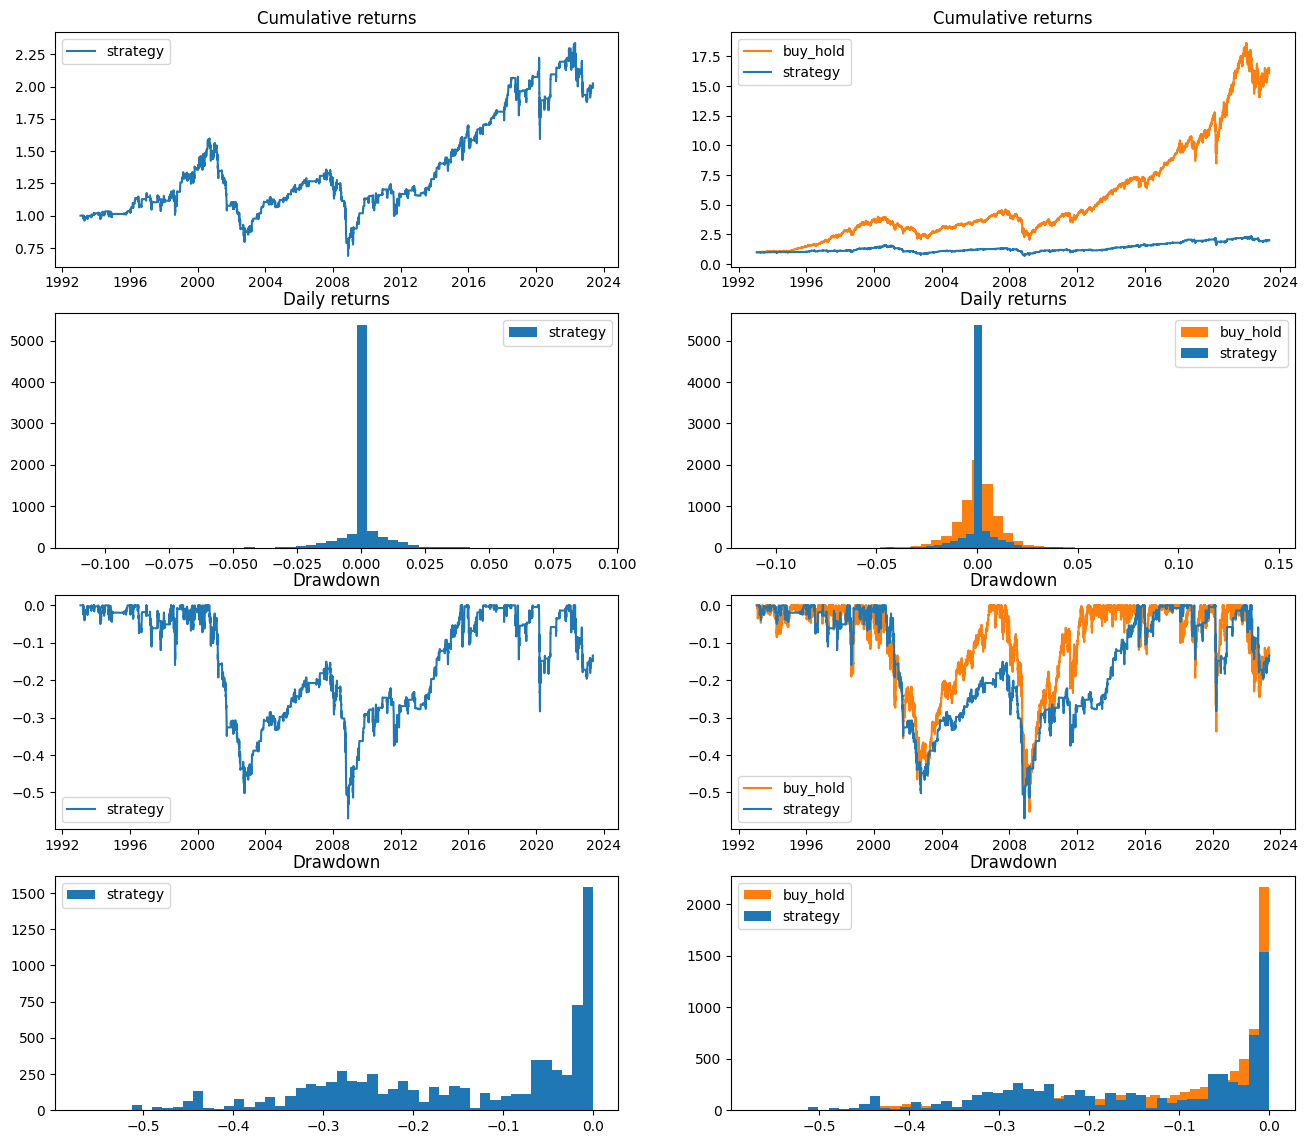

In [3]:
bt.analyse()
bt.plot_graphs()

In [4]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          0.0235765163784607
buy_hold annual return:     0.09687396348963162
Annualised vol:             0.13695315415999199
buy_hold annual vol:        0.18894833368916436
Sharpe ratio:               0.17215022555024942
buy_hold Sharpe ratio:      0.5127008087247665


In [5]:
bt.trade_record.analyse()
bt.trade_record.stats

{'num_wins': 131,
 'num_loss': 56,
 'win_rate': 0.7005347593582888,
 'profit_total': 1001836.2831897741,
 'profit_mean': 5357.413279089701,
 'returns_mean': 0.00477661294242487,
 'returns_std': 0.04434685911622584,
 'time_in_trade_mean': 21.13368983957219,
 'time_in_trade_std': 11.955485930683336,
 'capital_at_risk_mean': 1341446.2769279175,
 'win_returns_mean': 0.02486676680379992,
 'win_returns_std': 0.01894197660301074,
 'win_profit_mean': 32998.8267147996,
 'win_time_in_trade_mean': 16.519083969465647,
 'win_time_in_trade_std': 8.582048477928232,
 'loss_returns_mean': -0.04221999698329177,
 'loss_returns_std': 0.05091746254427996,
 'loss_profit_mean': -59303.75029373168,
 'loss_time_in_trade_mean': 31.928571428571427,
 'loss_time_in_trade_std': 11.828866299103982}

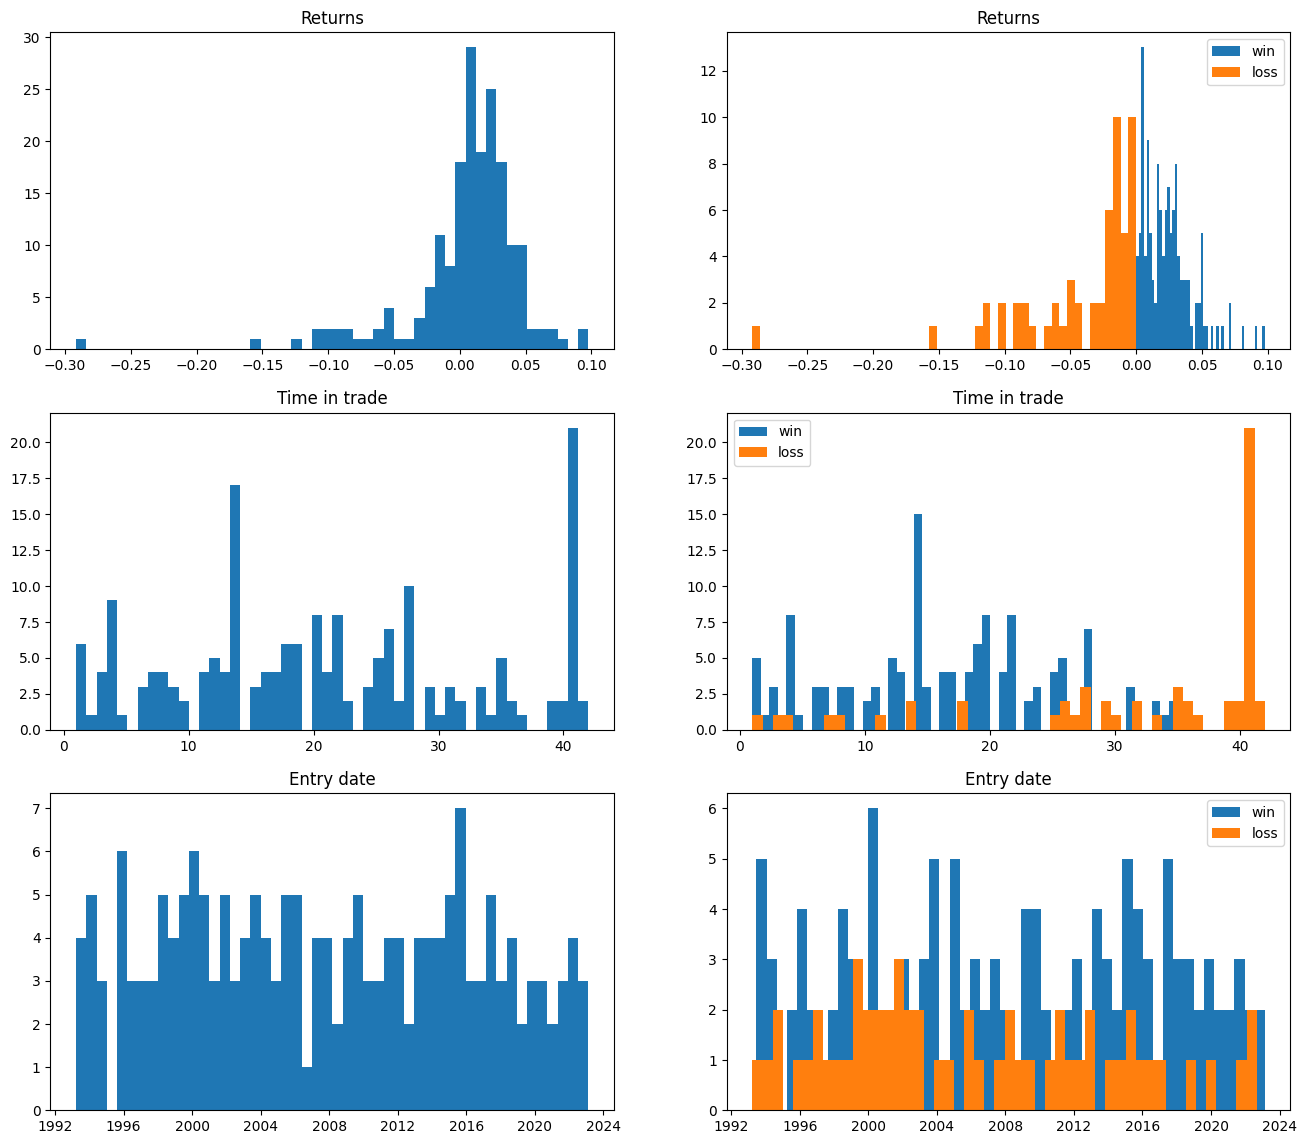

In [6]:
bt.trade_record.plot_graphs()

<Axes: >

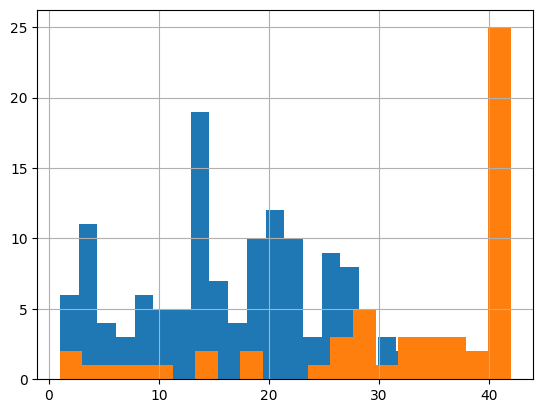

In [7]:
bt.trade_record.win_records['time_in_trade'].hist(bins=20)
bt.trade_record.loss_records['time_in_trade'].hist(bins=20)

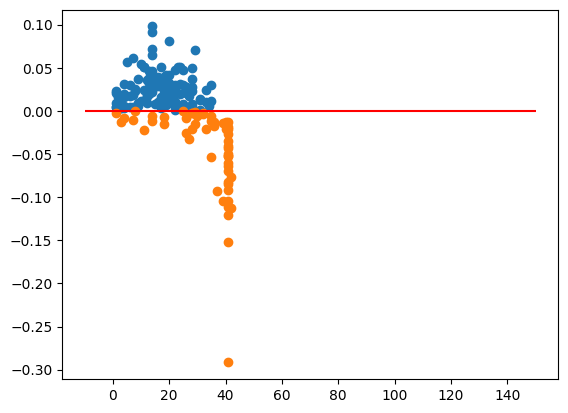

In [8]:
plt.scatter(bt.trade_record.win_records['time_in_trade'], bt.trade_record.win_records['returns'])
plt.scatter(bt.trade_record.loss_records['time_in_trade'], bt.trade_record.loss_records['returns'])
plt.hlines(0, -10, 150, color='red')